# Config

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Credit Card Fraud Analysis'

/content/drive/MyDrive/Credit Card Fraud Analysis


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
!pip install pretty_errors pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=9021d28c8cca29642be6dc345fec8fc802da77b5a969f00f547c07a071e2d247
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [5]:
from pyspark.sql import SparkSession
import os, sys, matplotlib.pyplot as plt, seaborn as sns
from src.data_visualization import *
import plotly.express as px

In [6]:
from config import PROJECT_PATH
import pretty_errors

In [7]:
train_dir = os.path.join(PROJECT_PATH, 'input/fraudTrain.csv')
test_dir = os.path.join(PROJECT_PATH, 'input/fraudTest.csv')

In [8]:
from pyspark.sql import functions as F
import pandas as pd
import numpy as np

In [9]:
sc = SparkSession.builder \
    .appName("fraudDetection") \
    .config("spark.driver.maxResultSize", "3g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()
train = sc.read.csv(train_dir, inferSchema = True, header = True)
test = sc.read.csv(test_dir, inferSchema = True, header = True)

In [10]:
all_data = train.union(test)
all_data.show()

+---+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+
|_c0|trans_date_trans_time|             cc_num|            merchant|     category|   amt|      first|     last|gender|              street|                city|state|  zip|    lat|              long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat|        merch_long|is_fraud|
+---+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+
|  0|  2019-01-01 00:00:18|   2703186189

# Data Cleaning

In [11]:
irrelevant_columns =  ['_c0', 'first', 'last', 'cc_num', 'trans_num', 'street', 'zip', 'city']
others = [column for column in all_data.columns if column not in irrelevant_columns]
all_data = all_data.select(others)

In [ ]:
null_columns = {column: all_data.select(column).where(F.col(column).isNull()).count() for column in all_data.columns}
null_columns

{'trans_date_trans_time': 0,
 'merchant': 0,
 'category': 0,
 'amt': 0,
 'gender': 0,
 'state': 0,
 'lat': 0,
 'long': 0,
 'city_pop': 0,
 'job': 0,
 'dob': 0,
 'unix_time': 0,
 'merch_lat': 0,
 'merch_long': 0,
 'is_fraud': 0}

In [12]:
all_data = all_data.dropDuplicates()

# General info about the data

In [13]:
all_data = all_data.withColumn('age', F.round(F.datediff(F.current_date(), F.col('dob')) / 365))

In [ ]:
cols = ['job', 'age', 'state', 'gender']
customers = all_data.select(cols).groupBy(cols).count().orderBy('count')

In [ ]:
customers.show()

In [ ]:
# Total customers in the dataset
print(f'Total customers in the dataset is: {customers.count()}')

In [ ]:
columns = ['gender', 'is_fraud']
fig = barplots(all_data.select(columns).toPandas(), columns = columns, shape = (1, 2))

`The gender column is balanced, while the target variable is not.`

In [ ]:
crosstabs(all_data.select(['gender', 'is_fraud']).toPandas(), ['gender', 'is_fraud'], shape = (1, 1), figsize = (5, 5))

`Apparently, there is no association between the two categories, but we'll test with the Chi-Square test`

**Null Hypothesis (H0)**
The null hypothesis states that there is no association between gender and fraud. In other words, the distribution of fraud cases is independent of gender.

$H0$
:
There is no association between gender and fraud.

**Alternative Hypothesis (H1)**
The alternative hypothesis states that there is an association between gender and fraud. In other words, the distribution of fraud cases depends on gender.

$H1$
:
There is an association between gender and fraud.


In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline


string_indexer = StringIndexer(inputCols = ['gender'], outputCols = ['gender_idx'])
vector_assembler = VectorAssembler(inputCols = ["gender_idx"], outputCol = "gender_vec")
all_data_vec = Pipeline(stages = [string_indexer, vector_assembler]).fit(all_data).transform(all_data)
all_data_vec.show()

In [ ]:
from pyspark.ml.stat import ChiSquareTest
chiSqResult = ChiSquareTest.test(all_data_vec, 'gender_vec', 'is_fraud')
chiSqResult.show()

`Since the pValue is greater than 0.05, we cannot reject the null hypothesis, which means that there is no association between gender and fraud.`

# Transaction date and time

In [14]:
all_data = all_data.withColumn('trans_hour', F.hour(F.to_timestamp(F.col('trans_date_trans_time'))))

In [ ]:
fig = histograms(all_data.select('trans_hour').toPandas(), x = ['trans_hour'], shape = (1, 1))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
counts = all_data.groupby(['trans_hour', 'is_fraud']).count().orderBy('trans_hour')
counts = counts.withColumnRenamed('count', 'counts')

In [ ]:
fig = target_histograms(all_data.select('trans_hour', 'is_fraud').toPandas(),
                  x = ['trans_hour'],
                  y = 'is_fraud',
                  shape = (1, 1))

Output hidden; open in https://colab.research.google.com to view.

$$
P(x = \{0, ..., 23\}/y = \{0, 1\})
$$

In [ ]:
total_counts = counts.groupBy('is_fraud').agg(F.sum('counts').alias('total_counts')).collect()
total_counts_dict = {row['is_fraud']: row['total_counts'] for row in total_counts}

p_x_given_y = counts.withColumn('p_x_given_y',
                                F.col('counts') / F.when(F.col('is_fraud') == 1, total_counts_dict[1])
                                                      .otherwise(total_counts_dict[0])) \
                   .withColumn('class', F.when(F.col('is_fraud') == 1, F.lit('Fraud')).otherwise(F.lit('Not Fraud')))

In [ ]:
p_x_given_y = p_x_given_y.toPandas()

In [ ]:
p_x_given_y.head()

,trans_hour,is_fraud,counts,p_x_given_y,class
0,0,0,59832,0.032469,Not Fraud
1,0,1,823,0.085276,Fraud
2,1,0,60503,0.032833,Not Fraud
3,1,1,827,0.085691,Fraud
4,2,1,793,0.082168,Fraud


In [ ]:
fig = px.line(p_x_given_y,
              x = 'trans_hour',
              y = 'p_x_given_y',
              labels = {'x': 'Hour of the day', 'y': 'Probability'},
              title = 'Probability Distribution',
              line_shape = 'linear',
              color = 'class')


fig.show()

`It seems that frauds are likely to happen at night after 21 and before the morning.`

In [ ]:
import scipy.stats as stats

In [ ]:
hours_fraud = all_data.select('trans_hour', 'is_fraud').toPandas()
stats.mannwhitneyu(hours_fraud[hours_fraud['is_fraud'] == 1]['trans_hour'], hours_fraud[hours_fraud['is_fraud'] == 0]['trans_hour'])

MannwhitneyuResult(statistic=10414082581.5, pvalue=7.295924268803254e-186)

In [ ]:
size = len(hours_fraud[hours_fraud['is_fraud'] == 1])
stats.wilcoxon(hours_fraud[hours_fraud['is_fraud'] == 1]['trans_hour'], hours_fraud[hours_fraud['is_fraud'] == 0]['trans_hour'].sample(size))

WilcoxonResult(statistic=18613858.0, pvalue=4.4273939504363136e-26)

`From these 2 tests, we can confirm our assumptions that there is an association between frauds and transaction hours`

# Amount, Age and unix_time columns

In [18]:
numerical_data = all_data.select('amt', 'age', 'unix_time', 'is_fraud', F.log('amt')).withColumnRenamed('ln(amt)', 'ln_amt').toPandas()
numerical_data.head()

,amt,age,unix_time,is_fraud,ln_amt
0,8.34,97.0,1325383009,0,2.121063
1,128.24,61.0,1325385529,0,4.853904
2,68.07,41.0,1325390805,0,4.220537
3,3.68,66.0,1325403046,0,1.302913
4,134.75,98.0,1325404958,0,4.903421


In [ ]:
fig = histograms(numerical_data, x = ['age', 'amt'], shape = (1, 2))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig = histograms(numerical_data, x = ['unix_time'], shape = (1, 1))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig = px.histogram(numerical_data, x = 'ln_amt')
fig.show(render = 'colab')
fig.write_image('results/ln_amt.png')

`Amount column contains outliers`

In [ ]:
q25, q50, q75 = np.percentile(numerical_data['amt'], [25, 5, 75])
iqr = q75 - q25
_min, _max = q25 - 1.5 * iqr, q75 + 1.5 * iqr
print(_min, q25, q50, q75, _max)

-100.55 9.64 2.44 83.1 193.29


In [ ]:
# Number of rows considered as outilers
len(numerical_data) - len(numerical_data[numerical_data['amt'] < _max]['amt'])

95071

In [ ]:
target_boxplots(numerical_data, x = ['amt', 'age'], y = 'is_fraud', shape = (1, 2))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
target_boxplots(numerical_data, x = ['ln_amt', 'age'], y = 'is_fraud', shape = (1, 2))

Plotting boxplots: 100%|██████████| 2/2 [00:00<00:00, 44.76it/s]


`We can see a difference now between fraudulent and non fraudulent transaction`

In [ ]:
import scipy.stats as stats

fraud_amt = numerical_data[numerical_data['is_fraud'] == 1]['ln(amt)']
non_fraud_amt = numerical_data[numerical_data['is_fraud'] == 0]['ln(amt)'].sample(len(fraud_amt))

assert len(fraud_amt) == len(non_fraud_amt)
stats.mannwhitneyu(non_fraud_amt, fraud_amt)

MannwhitneyuResult(statistic=15336252.0, pvalue=0.0)

In [16]:
import pandas as pd
import seaborn as sns, matplotlib.pyplot as plt  # noqa: E401
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pretty_errors
import itertools
from tqdm import tqdm


In [39]:
fig = scatter_plots(numerical_data, x = ['amt', 'age', 'unix_time'], y = 'is_fraud', shape = (1, 3))

100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


# City population

In [26]:
city_pop_data = all_data.select('city_pop', 'is_fraud').toPandas()

In [29]:
fig = histograms(city_pop_data, x = ['city_pop'], shape = (1, 1))

Output hidden; open in https://colab.research.google.com to view.

In [31]:
fig = target_histograms(city_pop_data, x = ['city_pop'], y = 'is_fraud', shape = (1, 1))

Output hidden; open in https://colab.research.google.com to view.

In [32]:
city_pop_data['ln(city_pop)'] = np.log(city_pop_data['city_pop'])
city_pop_data['sqrt(city_pop)'] = np.sqrt(city_pop_data['city_pop'])

In [37]:
fig = histograms(city_pop_data, x = ['ln(city_pop)', 'sqrt(city_pop)'], shape = (1, 2))

Plotting histograms: 100%|██████████| 2/2 [00:00<00:00, 79.59it/s]


In [36]:
fig = target_histograms(city_pop_data, x = ['ln(city_pop)', 'sqrt(city_pop)'], y = 'is_fraud', shape = (1, 2))

Plotting histograms grouped by is_fraud column: 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]


`No difference between both`

# Category column

In [ ]:
category_data = all_data.select('category', 'is_fraud').toPandas()

<Axes: xlabel='category'>

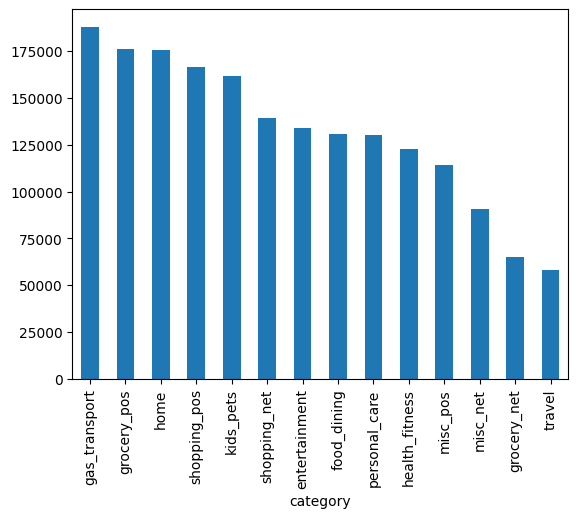

In [ ]:
category_data['category'].value_counts().plot(kind = 'bar', x = 'category', y = 'count')

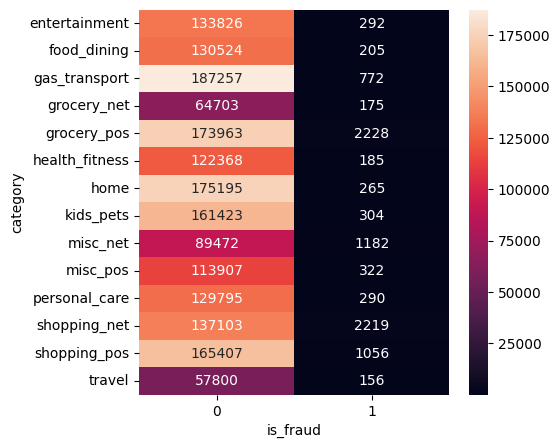

In [ ]:
crosstabs(category_data, ['category', 'is_fraud'], shape = (1, 1), figsize = (5, 5))

In [ ]:
string_indexer = StringIndexer(inputCols = ['category'], outputCols = ['category_idx'])
vector_assembler = VectorAssembler(inputCols = ["category_idx"], outputCol = "category_vec")
all_data_vec = Pipeline(stages = [string_indexer, vector_assembler]).fit(all_data_vec).transform(all_data_vec)
all_data_vec.show()

+---------------------+--------------------+--------------+------+------+-----+-------+---------+--------+--------------------+----------+----------+------------------+-------------------+--------+----+----------+----------+------------+------------+
|trans_date_trans_time|            merchant|      category|   amt|gender|state|    lat|     long|city_pop|                 job|       dob| unix_time|         merch_lat|         merch_long|is_fraud| age|gender_idx|gender_vec|category_idx|category_vec|
+---------------------+--------------------+--------------+------+------+-----+-------+---------+--------+--------------------+----------+----------+------------------+-------------------+--------+----+----------+----------+------------+------------+
|  2019-01-01 01:56:49| fraud_Pacocha-Bauch|  shopping_pos|  8.34|     M|   NY|43.0622| -77.2218|    9565| Exhibition designer|1927-12-11|1325383009|         42.624988|         -76.508987|       0|97.0|       1.0|     [1.0]|         3.0|       [3.

In [ ]:
chiSqResult = ChiSquareTest.test(all_data_vec, 'category_vec', 'is_fraud')
chiSqResult.show()

+-------+----------------+-------------------+
|pValues|degreesOfFreedom|         statistics|
+-------+----------------+-------------------+
|  [0.0]|            [13]|[8329.139945520074]|
+-------+----------------+-------------------+



`We have a pValues less than 0.05, so we can assume that frauds are related to transaction categories`

``

# State column

In [ ]:
state_data = all_data.select('state', 'is_fraud').toPandas()

<Axes: xlabel='state'>

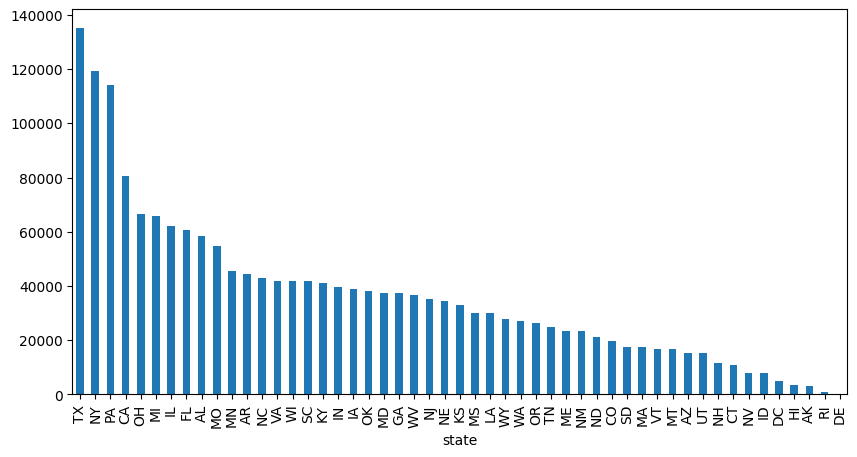

In [ ]:
state_data['state'].value_counts().plot(kind = 'bar', x = 'state', y = 'count', figsize = (10, 5))

In [ ]:
string_indexer = StringIndexer(inputCols = ['state'], outputCols = ['state_idx'])
vector_assembler = VectorAssembler(inputCols = ["state_idx"], outputCol = "state_vec")
all_data_vec = Pipeline(stages = [string_indexer, vector_assembler]).fit(all_data_vec).transform(all_data_vec)
all_data_vec.show()

+---------------------+--------------------+--------------+------+------+-----+-------+---------+--------+--------------------+----------+----------+------------------+-------------------+--------+----+----------+----------+------------+------------+---------+---------+
|trans_date_trans_time|            merchant|      category|   amt|gender|state|    lat|     long|city_pop|                 job|       dob| unix_time|         merch_lat|         merch_long|is_fraud| age|gender_idx|gender_vec|category_idx|category_vec|state_idx|state_vec|
+---------------------+--------------------+--------------+------+------+-----+-------+---------+--------+--------------------+----------+----------+------------------+-------------------+--------+----+----------+----------+------------+------------+---------+---------+
|  2019-01-01 01:56:49| fraud_Pacocha-Bauch|  shopping_pos|  8.34|     M|   NY|43.0622| -77.2218|    9565| Exhibition designer|1927-12-11|1325383009|         42.624988|         -76.508987

In [ ]:
chiSqResult = ChiSquareTest.test(all_data_vec, 'state_vec', 'is_fraud')
chiSqResult.show()

+-------+----------------+--------------------+
|pValues|degreesOfFreedom|          statistics|
+-------+----------------+--------------------+
|  [0.0]|            [50]|[2022.1228324519125]|
+-------+----------------+--------------------+



# Long and lat

In [ ]:
coordinates_data = all_data.select('long', 'lat', 'merch_long', 'merch_lat', 'is_fraud').toPandas()

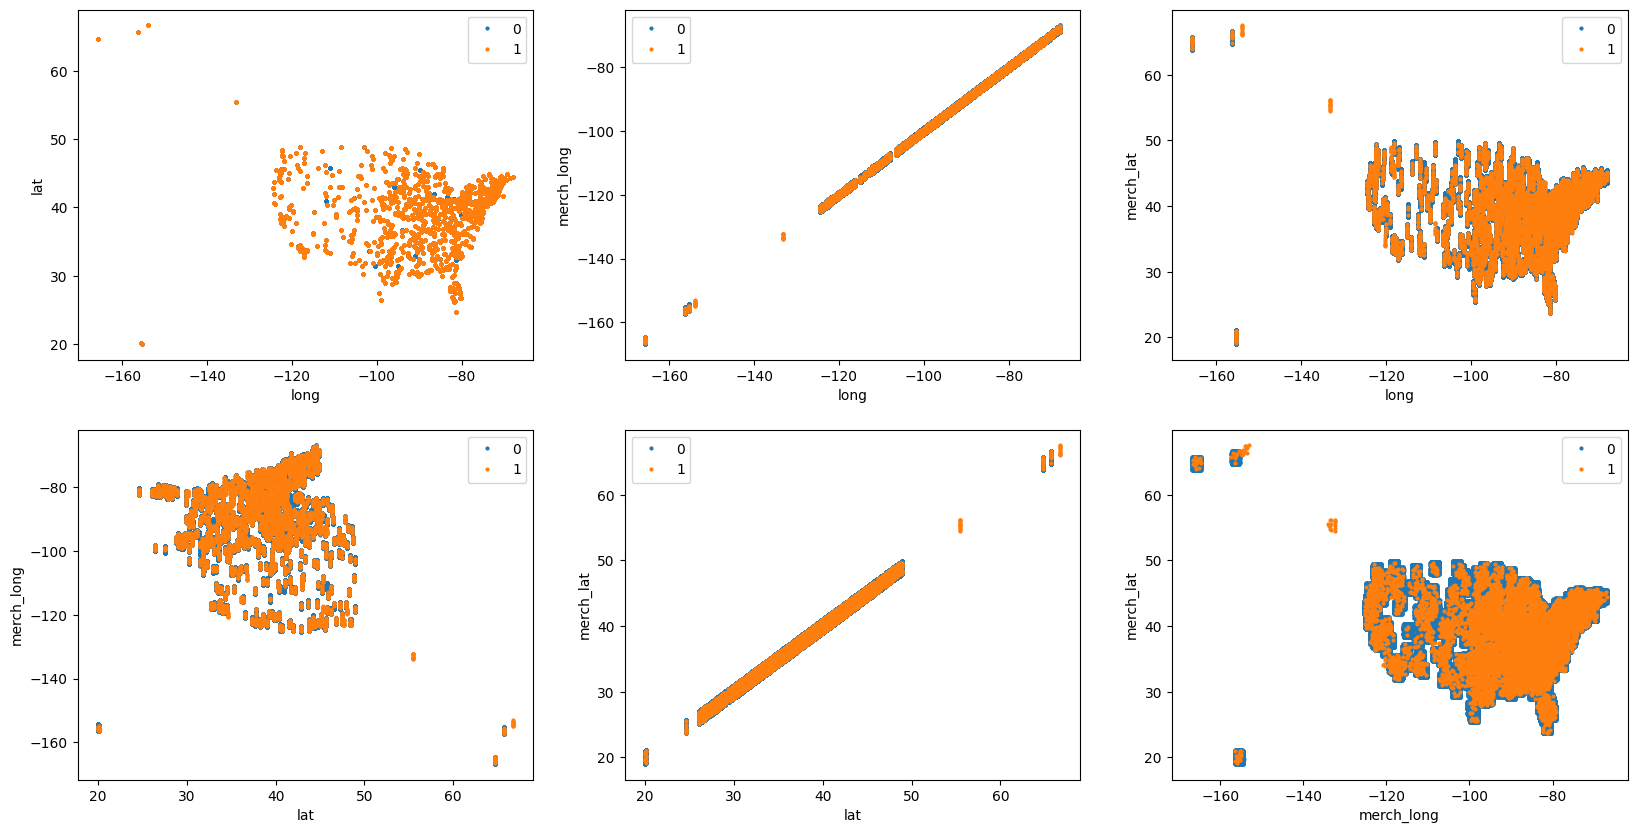

In [ ]:
scatter_plots(coordinates_data, x = ['long', 'lat', 'merch_long', 'merch_lat'], y = 'is_fraud', shape = (2, 3), figsize = (20, 10))

`Not a big difference between fraudulent and non fraudulent transactions`

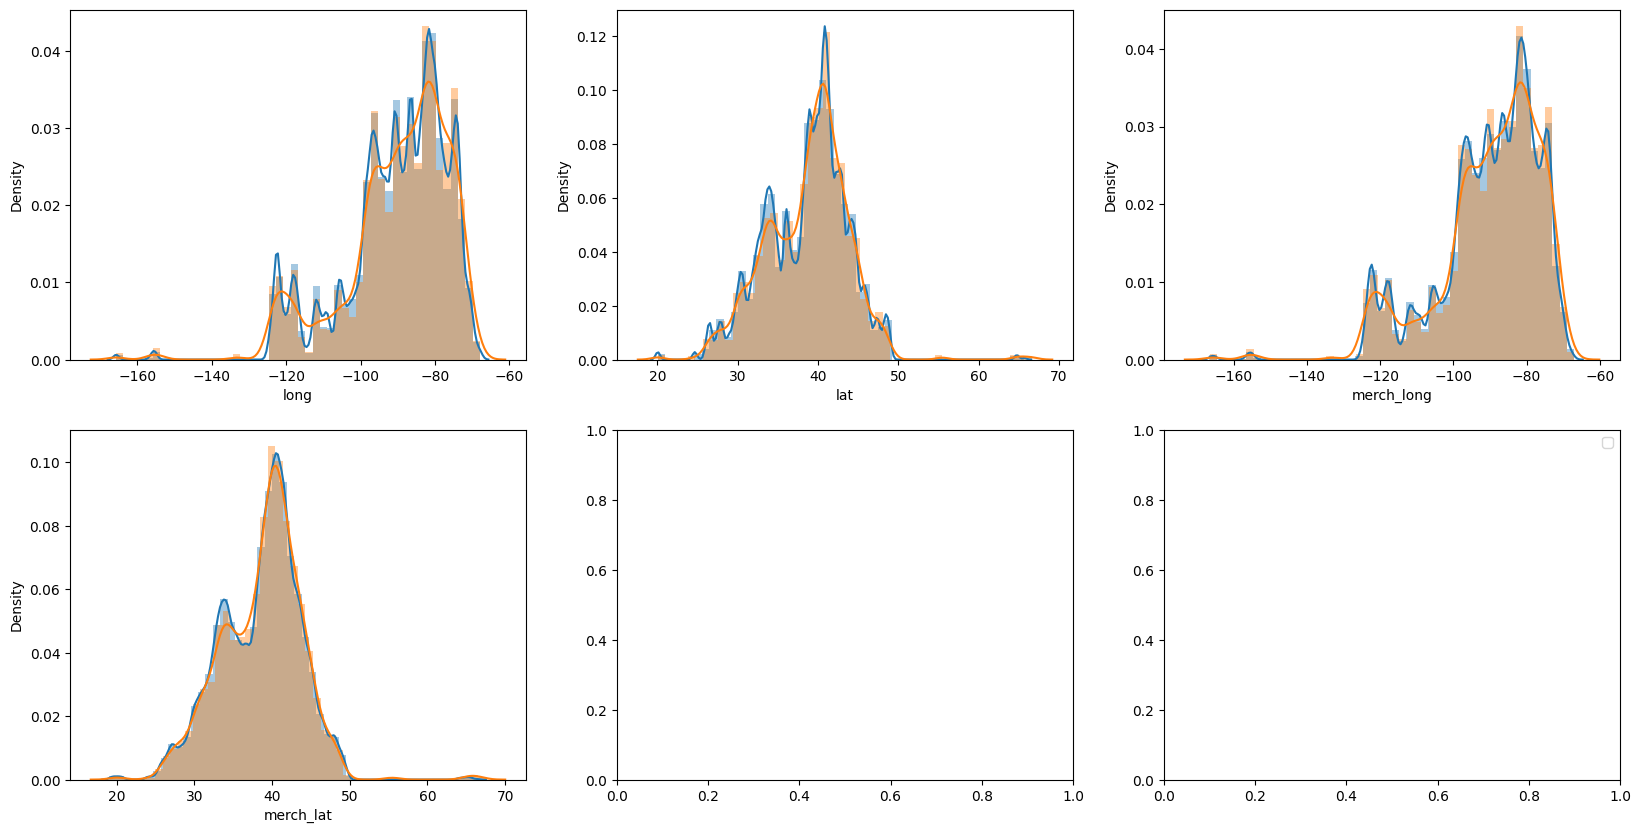

In [ ]:
target_histograms(
    coordinates_data,
    x = ['long', 'lat', 'merch_long', 'merch_lat'],
    y = 'is_fraud',
    shape = (2, 3),
    figsize = (20, 10)
)

# Saving data

In [ ]:
train = train.withColumn('trans_hour', F.hour(F.to_timestamp(F.col('trans_date_trans_time'))))
test = test.withColumn('trans_hour', F.hour(F.to_timestamp(F.col('trans_date_trans_time'))))

In [ ]:
train = train.withColumn('age', F.round(F.datediff(F.current_date(), F.col('dob')) / 365))
test = test.withColumn('age', F.round(F.datediff(F.current_date(), F.col('dob')) / 365))

In [ ]:
finalTrain = train.select('amt', 'age', 'trans_hour', 'state', 'is_fraud', 'category')
finalTest = test.select('amt', 'age', 'trans_hour', 'state', 'is_fraud', 'category')

In [ ]:
output_path = "Datasets"

finalTrain.write.parquet(os.path.join(output_path, 'finalTrain.parquet'))
finalTest.write.parquet(os.path.join(output_path, 'finalTest.parquet'))

In [ ]:
sc.stop()